In [1]:
#Set the seed
import numpy as np
np.random.seed(578)
import tensorflow as tf
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
import keras
import matplotlib.pyplot as plt
from keras.models import Model
from keras.layers import Input, Add, Activation, Dropout, Flatten, Dense
from keras.layers.convolutional import Convolution2D, MaxPooling2D, AveragePooling2D
from keras.layers.normalization import BatchNormalization
from keras.datasets import cifar10
import keras.callbacks as callbacks
import keras.utils.np_utils as kutils
from keras.preprocessing.image import ImageDataGenerator
from keras import backend as K
import keras.utils.np_utils as kutils

C:\Users\xiang\Anaconda3\envs\tensorflow\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
#define the initial convolutional layer
def First_setup(input):
    #using he_normal initialization
    mod = Convolution2D(16,  kernel_size=(3,3), padding = 'same', kernel_initializer='he_normal',  use_bias=False)(input)
    mod = BatchNormalization(momentum=0.1, epsilon=1e-5, gamma_initializer='uniform')(mod)
    mod = Activation('relu')(mod)
    return mod

In [3]:
#define the block convolutional layer
def convolution_block(input, mul=1, k=1, dropout=0):
    start = input
    
    mod = BatchNormalization(momentum=0.1, epsilon=1e-5, gamma_initializer='uniform')(input)
    mod = Activation('relu')(mod)
    mod = Convolution2D(16*mul* k, kernel_size= (3, 3), padding='same', kernel_initializer='he_normal',use_bias=False)(mod)
    #give the model a dropout option
    if dropout != 0: 
        mod = Dropout(dropout)(mod)

    mod = BatchNormalization(momentum=0.1, epsilon=1e-5, gamma_initializer='uniform')(mod)
    mod = Activation('relu')(mod)
    mod = Convolution2D(16*mul*k,  kernel_size=(3, 3), padding='same', kernel_initializer='he_normal',use_bias=False)(mod)
    #Merge layer
    result = Add()([start, mod])
    return result

In [4]:
#define the layer that expand the convolution size
def size_incre(input, mul, k, strides):
    mod = Convolution2D(16*mul*k, kernel_size=(3, 3), padding='same', kernel_initializer='he_normal', use_bias=False, strides=strides)(input)
    mod = BatchNormalization(momentum=0.1, epsilon=1e-5, gamma_initializer='uniform')(mod)
    mod = Activation('relu')(mod)
    mod = Convolution2D(16*mul*k,  kernel_size=(3, 3), padding='same', kernel_initializer='he_normal', use_bias=False)(mod)
    temp = Convolution2D(16*mul*k,  kernel_size=(1, 1), padding='same', kernel_initializer='he_normal', use_bias=False, strides=strides)(input)
    #Merge layer
    result = Add()([mod, temp])
    return result

In [5]:
def wide_residual_network(dim, nb_classes, k=1, dropout=0):

    init = Input(shape=dim)
    #initial layer
    mod = First_setup(init)
    #increase layer
    mod = size_incre(mod, 1, k,(1,1))
    #First size
    mod = convolution_block(mod,1, k, dropout=dropout)

    mod = BatchNormalization(momentum=0.1, epsilon=1e-5, gamma_initializer='uniform')(mod)
    mod = Activation('relu')(mod)

    mod = size_incre(mod, 2, k,(2,2))
    
    mod = convolution_block(mod,2, k, dropout=dropout)

    mod = BatchNormalization(momentum=0.1, epsilon=1e-5, gamma_initializer='uniform')(mod)
    mod = Activation('relu')(mod)

    mod = size_incre(mod, 4, k,(2,2))
    
    mod = convolution_block(mod,4, k, dropout=dropout)
        
    mod = BatchNormalization(momentum=0.1, epsilon=1e-5, gamma_initializer='uniform')(mod)
    mod = Activation('relu')(mod)
    
    mod = AveragePooling2D((8, 8))(mod)
    mod = Flatten()(mod)

    mod = Dense(10, activation='softmax')(mod)
    return Model(init, mod)

In [6]:
from keras.datasets import cifar10
batch_size = 100
nb_epoch = 200

(X_train, Y_train), (X_test, Y_test) = cifar10.load_data()
X_train = X_train.astype('float64')
X_test = X_test.astype('float64')

In [7]:
X_train = (X_train - X_train.mean(axis=0)) / (X_train.std(axis=0))
X_test = (X_test - X_test.mean(axis=0)) / (X_test.std(axis=0))

In [8]:
Y_train = kutils.to_categorical(Y_train)
Y_test = kutils.to_categorical(Y_test)

In [9]:
X_train.reshape(X_train.shape[0], -1).shape

(50000, 3072)

In [9]:
datagen = ImageDataGenerator(rotation_range=10,
                               width_shift_range=5./32,
                               height_shift_range=5./32,
                               zca_whitening=True)

C:\Users\xiang\Anaconda3\envs\tensorflow\lib\site-packages\keras\preprocessing\image.py:514: UserWarning: This ImageDataGenerator specifies `zca_whitening`, which overrides setting of `featurewise_center`.
  warnings.warn('This ImageDataGenerator specifies '


In [11]:
datagen.fit(X_train)

In [12]:
for i in range(len(X_test)):
    X_test[i] = datagen.standardize(X_test[i])

In [10]:
model = wide_residual_network(X_train.shape[1:], nb_classes=10,  k=10)

In [12]:
model.compile(loss="categorical_crossentropy", optimizer='adam', metrics=["acc"])

In [13]:
class SaveHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.losses_train=[]
        self.acc_train=[]
        self.losses_test=[]
        self.acc_test=[]
    def on_epoch_end(self, epoch, logs={}):
        self.losses_train.append(logs.get('loss'))
        self.acc_train.append(logs.get('acc'))
        self.losses_test.append(logs.get('val_loss'))
        self.acc_test.append(logs.get('val_acc'))
history =SaveHistory()

In [14]:
batch_size = 100
epochs = 200

In [17]:
model.fit_generator(datagen.flow(X_train, Y_train,
                                 batch_size=batch_size),
                    steps_per_epoch=X_train.shape[0] // batch_size,
                    epochs=epochs,
                    validation_data=(X_test, Y_test),validation_steps=X_test.shape[0] // batch_size, callbacks=[history])

Epoch 1/200
500/500 [==============================] - 216s 432ms/step - loss: 1.4667 - acc: 0.4561 - val_loss: 1.3305 - val_acc: 0.5534
Epoch 2/200
500/500 [==============================] - 211s 423ms/step - loss: 0.9558 - acc: 0.6597 - val_loss: 0.9988 - val_acc: 0.6625
Epoch 3/200
500/500 [==============================] - 212s 424ms/step - loss: 0.7391 - acc: 0.7418 - val_loss: 0.6956 - val_acc: 0.7608
Epoch 4/200
500/500 [==============================] - 212s 424ms/step - loss: 0.6012 - acc: 0.7916 - val_loss: 0.6142 - val_acc: 0.7907
Epoch 5/200
500/500 [==============================] - 213s 425ms/step - loss: 0.5018 - acc: 0.8276 - val_loss: 0.6797 - val_acc: 0.7821
Epoch 6/200
500/500 [==============================] - 213s 425ms/step - loss: 0.4403 - acc: 0.8480 - val_loss: 0.5324 - val_acc: 0.8221
Epoch 7/200
500/500 [==============================] - 213s 425ms/step - loss: 0.3912 - acc: 0.8640 - val_loss: 0.5875 - val_acc: 0.8131
Epoch 8/200
500/500 [====================

500/500 [==============================] - 211s 423ms/step - loss: 0.0136 - acc: 0.9955 - val_loss: 0.5726 - val_acc: 0.9046
Epoch 120/200
500/500 [==============================] - 211s 422ms/step - loss: 0.0159 - acc: 0.9946 - val_loss: 0.5433 - val_acc: 0.9088
Epoch 121/200
500/500 [==============================] - 211s 423ms/step - loss: 0.0160 - acc: 0.9944 - val_loss: 0.5780 - val_acc: 0.9052
Epoch 122/200
500/500 [==============================] - 211s 422ms/step - loss: 0.0171 - acc: 0.9942 - val_loss: 0.5470 - val_acc: 0.9040
Epoch 123/200
500/500 [==============================] - 211s 422ms/step - loss: 0.0152 - acc: 0.9951 - val_loss: 0.5889 - val_acc: 0.9006
Epoch 124/200
500/500 [==============================] - 211s 422ms/step - loss: 0.0153 - acc: 0.9948 - val_loss: 0.5881 - val_acc: 0.9050
Epoch 125/200
500/500 [==============================] - 211s 423ms/step - loss: 0.0145 - acc: 0.9951 - val_loss: 0.5964 - val_acc: 0.9016
Epoch 126/200
500/500 [==================

500/500 [==============================] - 211s 423ms/step - loss: 0.0105 - acc: 0.9968 - val_loss: 0.6750 - val_acc: 0.8980
Epoch 179/200
500/500 [==============================] - 211s 423ms/step - loss: 0.0123 - acc: 0.9955 - val_loss: 0.5889 - val_acc: 0.9084
Epoch 180/200
500/500 [==============================] - 211s 423ms/step - loss: 0.0126 - acc: 0.9961 - val_loss: 0.5515 - val_acc: 0.9088
Epoch 181/200
500/500 [==============================] - 211s 422ms/step - loss: 0.0105 - acc: 0.9966 - val_loss: 0.6304 - val_acc: 0.8998
Epoch 182/200
500/500 [==============================] - 211s 422ms/step - loss: 0.0071 - acc: 0.9974 - val_loss: 0.6608 - val_acc: 0.8995
Epoch 183/200
500/500 [==============================] - 211s 422ms/step - loss: 0.0081 - acc: 0.9973 - val_loss: 0.6941 - val_acc: 0.9001
Epoch 184/200
500/500 [==============================] - 211s 422ms/step - loss: 0.0092 - acc: 0.9967 - val_loss: 0.5940 - val_acc: 0.9082
Epoch 185/200
500/500 [==================

In [18]:
pre = model.predict(X_test)

In [22]:
inverted = np.argmax(pre, axis=1)

In [23]:
inverted

array([3, 8, 1, ..., 5, 1, 7], dtype=int64)

In [24]:
import pandas as pd
df = pd.DataFrame({'pre': inverted
                  })

In [26]:
df.to_csv("zca_aug_prediction.csv")

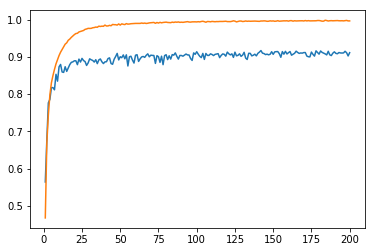

In [21]:
import matplotlib.pyplot as plt
plt.plot(range(1,201),df['test_acc'])
plt.plot(range(1,201),df['train_acc'])

In [23]:
np.max(df['test_acc'])

0.9168000018596649

In [27]:
from sklearn.metrics import confusion_matrix
(X_train, Y_train), (X_test, Y_test) = cifar10.load_data()
conf_arr = confusion_matrix(inverted, Y_test)

In [28]:
conf_arr

array([[951,   5,  16,  21,   7,   9,   5,   7,  30,   9],
       [  1, 965,   0,   2,   1,   2,   0,   0,  12,  22],
       [ 18,   0, 890,  31,  20,  24,  15,  10,   4,   2],
       [  0,   0,  12, 759,   7,  76,   6,   9,   2,   0],
       [  5,   0,  25,  32, 911,  24,   6,  15,   1,   0],
       [  0,   0,  19,  80,   8, 823,   2,   9,   0,   0],
       [  5,   1,  29,  47,  28,  21, 962,   2,   3,   1],
       [  1,   2,   5,  13,  14,  15,   2, 943,   3,   0],
       [ 14,   2,   2,   4,   1,   0,   1,   0, 930,   5],
       [  5,  25,   2,  11,   3,   6,   1,   5,  15, 961]], dtype=int64)

In [59]:
import itertools
import matplotlib.pyplot as plt


def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=28)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, fontsize=18)
    plt.yticks(tick_marks, classes, fontsize=18)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), fontsize=18,
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label', fontsize=28)
    plt.xlabel('Predicted label', fontsize=28)

Normalized confusion matrix


<Figure size 2880x2880 with 0 Axes>

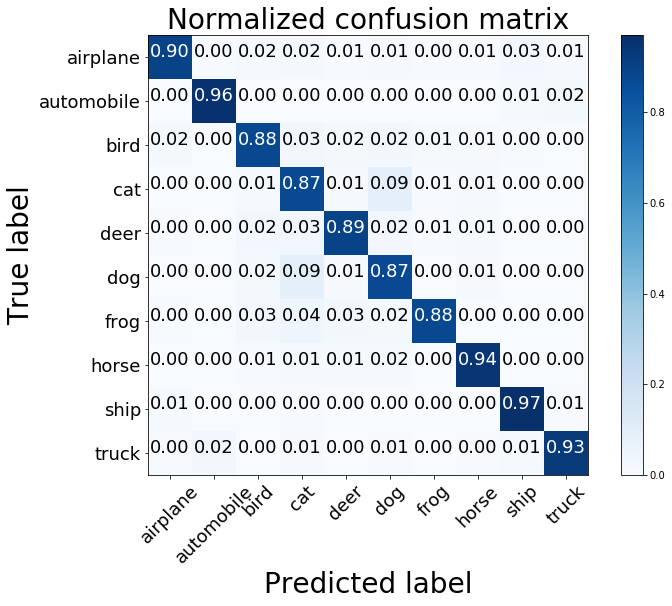

In [60]:
import matplotlib
class_names = ["airplane","automobile","bird","cat","deer","dog","frog","horse","ship","truck"]
plt.figure(figsize=(40,40))

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(conf_arr, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(12, 12)
fig.savefig('tt.png')
plt.show()